# import libraries

In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B

# basic assignment of variables

In [19]:
start_time = '20160311T064700'
end_time = '20160311T064900'
satellite = 'A'
sdir = Path("D:/cleo/master/pyaw/data/swarm/miles2018")
sfn_EFIA_TCT16 = Path("EFIA_TCT16.pkl")
sfn_MAGA_HR_1B = Path("MAGA_HR_1B.pkl")

# download data

In [20]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_EFIA_TCT16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_MAGA_HR_1B)

D:\cleo\master\pyaw\data\swarm\miles2018\EFIA_TCT16.pkl already exists, skip save.
D:\cleo\master\pyaw\data\swarm\miles2018\MAGA_HR_1B.pkl already exists, skip save.


# read data

In [21]:
df_e = pd.read_pickle(Path(sdir) / Path(sfn_EFIA_TCT16))
df_b = pd.read_pickle(Path(sdir) / Path(sfn_MAGA_HR_1B))
timestamps_e = df_e.index.values
timestamps_b = df_b.index.values

# magnetic field in NEC coordinate system

In [22]:
bn=[]
be=[]
bc=[]
for ndarray_ in df_b['B_NEC'].values:
    bn.append(ndarray_[0])
    be.append(ndarray_[1])
    bc.append(ndarray_[2])
bn = np.array(bn)
be = np.array(be)
bc = np.array(bc)

# electric field in NEC coordinate system

## electric field in satellite-track coordinate system

In [23]:
# todo:: i.e. S/C coordinate system (in the later part, I will treat the satellite-track coordinate system as the S/C system) (no it will have a negative difference)?
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values
Ehz = df_e['Ehz'].values
Evx = df_e['Evx'].values
Evy = df_e['Evy'].values
Evz = df_e['Evz'].values

### coordinate transformation from S/C coordinate system to NEC coordinate system

#### get rotation matrix

nec2sc, sc2nec (when deriving the rotation matrix, consider the rotation matrix from NEC to S/C and from S/C to NEC)

In [24]:
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values

In [25]:
theta = np.arctan(VsatE/VsatN)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
# Stack components to construct the rotation matrices
rotation_matrix = np.array([
    [cos_theta, sin_theta],
    [-sin_theta, cos_theta]
])
# Transpose axes to create a (3, 2, 2) array
rotation_matrix_2d_nec2sc = np.transpose(rotation_matrix, (2, 0, 1))
rotation_matrix_2d_sc2nec = rotation_matrix_2d_nec2sc.transpose(0, 2, 1)
del rotation_matrix

In [26]:
def do_rotation(vectors1,vectors2,rotation_matrix):
    vectors12 = np.stack((vectors1,vectors2),axis=1)
    vectors12_rotated = np.einsum('nij,nj->ni', rotation_matrix, vectors12)
    return vectors12_rotated[:,0],vectors12_rotated[:,1]

#### preprocess before rotation

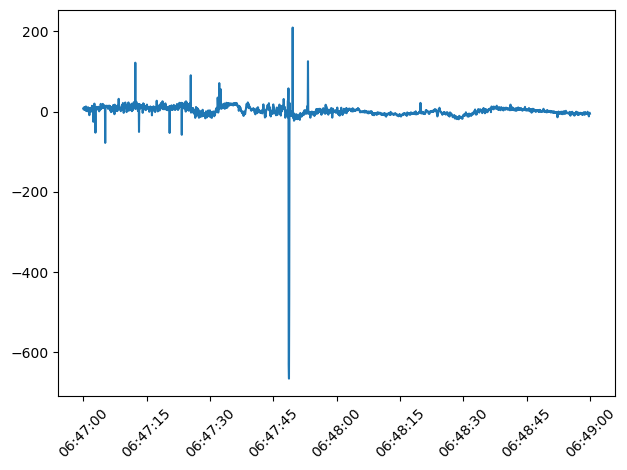

In [27]:
plt.plot(timestamps_e, Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [28]:
np.std(Ehx),np.mean(Ehx),np.max(Ehx),np.min(Ehx)

(26.03453, 1.4860274, 209.64946, -665.1797)

In [29]:
def set_outliers_nan(array,std_times: float = 1.0, print_: bool = True):
    array_copy = array.copy()
    threshold = std_times * np.std(array_copy)
    bursts = np.abs(array_copy - np.mean(array_copy)) > threshold
    array_copy[bursts] = np.nan
    return array_copy

Ehx_set_outliers_nan = set_outliers_nan(Ehx)
Ehy_set_outliers_nan = set_outliers_nan(Ehy)

In [30]:
def get_array_interpolated(x,y):
    """
    :param x: ndarray consisting of np.datetime64. Specifically in this notebook the dtype of the array is np.datetime64[ns]
    :param y:
    :return:
    """
    y_copy = y
    # Mask for missing values
    mask = np.isnan(y_copy)
    # Interpolate
    y_copy[mask] = interpolate.interp1d(x[~mask].astype('int'), y_copy[~mask], kind='linear')(
        x[mask].astype('int'))
    return y_copy

In [31]:
Ehx_set_outliers_nan_interpolated = get_array_interpolated(timestamps_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = get_array_interpolated(timestamps_e, Ehy_set_outliers_nan)

#### do rotation

In [32]:
Ehn,Ehe = do_rotation(-Ehx_set_outliers_nan_interpolated, -Ehy_set_outliers_nan_interpolated, rotation_matrix_2d_sc2nec)
# todo:: I add the negative sign to the x,y components of the electric field in the satellite-track coordinate system.

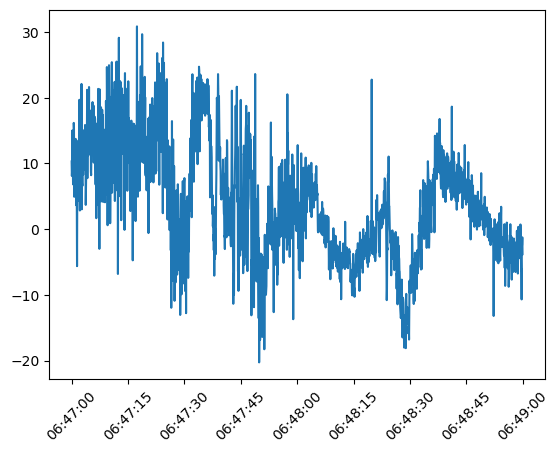

In [33]:
plt.plot(timestamps_e, Ehn)
plt.xticks(rotation=45)
plt.show()

# to verify the correlation between the satellite-track coordinate system and the S/C coordinate system

## IGRF13

NEC coordinate system

In [34]:
latitudes = df_e['Latitude'].values
longitudes = df_e['Longitude'].values
radiuses = df_e['Radius']/1e3  # km

In [35]:
from igrf13 import igrf_utils
# from importlib import reload
# reload(igrf_utils)

igrf_bn,igrf_be,igrf_bc = igrf_utils.get_igrf13_b_nec(timestamps_e, latitudes, longitudes, radiuses, igrf13shc_path="./igrf13/IGRF13.shc")

the whole loop takes time: 3.4414966106414795s


### do rotation

from NEC coordinate system to S/C coordinate system

In [36]:
igrf_b_sc_x,igrf_b_sc_y = do_rotation(igrf_bn, igrf_be, rotation_matrix_2d_nec2sc)

### compare IGRF magnetic field in S/C coordinate system with the magnetic field in the satellite-track coordinate system

In [37]:
Bx = df_e['Bx'].values
By = df_e['By'].values
Bz = df_e['Bz'].values

In [38]:
igrf_b_sc_x,Bx

(array([5985.84738024, 5987.41412578, 5989.00885973, ..., 9248.54053443,
        9250.34402662, 9252.11641078]),
 array([-6025.4023, -6026.9688, -6028.56  , ..., -9247.887 , -9249.308 ,
        -9250.706 ], dtype=float32))

In [39]:
igrf_b_sc_y,By

(array([2528.52554331, 2528.90898771, 2529.29978926, ..., 3181.55301796,
        3181.84250689, 3182.12621555]),
 array([-2509.011 , -2509.4792, -2509.955 , ..., -3216.7092, -3217.0664,
        -3217.4177], dtype=float32))

In [42]:
np.array(igrf_bc),Bz

(array([47031.73096736, 47031.36768385, 47030.99772027, ...,
        45741.43486415, 45740.41479512, 45739.41210519]),
 array([47065.215, 47064.84 , 47064.453, ..., 45743.824, 45742.88 ,
        45741.934], dtype=float32))

### compare the Bx,By,Bz of EFIx_TCT16 download from VirES with EFIx_TCT16 download from ESA Swarm http database

In [119]:
import cdflib

fp = r"D:\cleo\master\pyaw\data\Swarm\miles2018\SW_EXPT_EFIA_TCT16_20160311T000000_20160311T065505_0302.cdf"

cdf_file = cdflib.CDF(fp)
info = cdf_file.cdf_info()

In [120]:
cdf_file.varattsget('Bx')

{'FIELDNAM': 'Bx',
 'CATDESC': 'Geomagnetic field x component in satellite-track coordinates, derived from the 1 Hz product.',
 'Type': 'CDF_FLOAT',
 'UNITS': 'nT',
 'VAR_TYPE': 'data',
 'DEPEND_0': 'Time',
 'DISPLAY_TYPE': 'time_series',
 'LABLAXIS': 'Bx',
 'VALIDMIN': -65000.0,
 'VALIDMAX': 65000.0}

In [121]:
Bx_local = cdf_file.varget('Bx')
timestamps_local = cdf_file.varget('Timestamp')

In [123]:
import numpy as np

# Create a numpy datetime object for Year 0, January 1, and the unit is millisecond
ad0_reference = np.datetime64('0000-01-01', 'ms')

# Convert the 'Timestamp' to datetime by adding the milliseconds since the epoch_reference
# Assuming 'Timestamp' is in milliseconds
timestamps_local = ad0_reference + np.array(timestamps_local, dtype='timedelta64[ms]')

# Print the first few datetime values
print(timestamps_local[:5])

['2016-03-11T00:00:00.006' '2016-03-11T00:00:00.068'
 '2016-03-11T00:00:00.131' '2016-03-11T00:00:00.193'
 '2016-03-11T00:00:00.256']


In [124]:
mask = np.where(timestamps_local > np.datetime64('2016-03-11T06:47:00'))
Bx_local = Bx_local[mask]
Bx_local

### conclusion

(x,y,z) in satellite-track coordinate system, in S/C coordinate system, it will be (-x,-y,z)

In [ ]:
# todo:: according to the doc of tct16, the x axis of the satellite-track coordinate system is in the direction of the satellite velocity that is same to the x axis of the S/C coordinate system??? so why there is a negative sign difference between the x and y components of the magnetic field in the satellite-track coordinate system and the S/C coordinate system?

# down-resample the MAGx_HR_1B data (50hz)

- 1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20). so when down-resampling the MAGx_HR_1B magnetic field data to 16hz, don't firstly filter the data?